In [1]:
import os
from data.source.pg_experiment import get_pg_experiment_dataframe
import polars as pl

from models.SimplifiedLightweightCNN import SimplifiedLightweightCNN
%load_ext autoreload
%autoreload 1
%aimport models.SimplifiedLightweightCNN
from models.SimpleCNN_v2 import train, evaluate
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from path import RESULT_DIRECTORY
import wandb

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
df_pron, df_tone = get_pg_experiment_dataframe(".ogg")

dataframe = df_tone.with_columns(word_id = pl.struct("word_id").rank("dense"))
# dataframe = dataframe.filter(pl.col("mother") == "polish")
dataframe = dataframe.filter(pl.col("stage") == 1)
# df_stageI_polish = df_stageI_polish.filter(pl.col("word_id") == 1)

N_WORDS = dataframe.select(pl.col("word_id").n_unique()).to_numpy()[0][0]
print(f"Number of unique words: {N_WORDS}")
print(f"Number of samples: {dataframe.shape[0]}")

get_pg_experiment_dataset(): WARNING, Dropped 2 rows with missing files
get_pg_experiment_dataset(): WARNING, Dropped 2 rows with missing files
Number of unique words: 12
Number of samples: 6016


In [3]:
dataframe

id_student,word_id,tone_assesment,rec_path,stage,univ,gender,mother,target_tone
i64,u32,list[i64],str,i32,str,str,str,list[i64]
763,10,[2],"""/home/tad1/Projects/AI/Mandari…",1,"""CLES_UMK2""","""f""","""polish""",[1]
1370,11,[1],"""/home/tad1/Projects/AI/Mandari…",1,"""MBI_2024""","""m""","""polish""",[1]
1021,1,[2],"""/home/tad1/Projects/AI/Mandari…",1,"""CLES_UMK3""","""f""","""polish""",[2]
351,6,[2],"""/home/tad1/Projects/AI/Mandari…",1,"""MBI_2022""","""f""","""polish""",[1]
102,12,[0],"""/home/tad1/Projects/AI/Mandari…",1,"""PG_CS_MA_1""","""m""","""polish""",[3]
…,…,…,…,…,…,…,…,…
1436,10,[0],"""/home/tad1/Projects/AI/Mandari…",1,"""MBI_2024""","""m""","""polish""",[1]
1438,10,[3],"""/home/tad1/Projects/AI/Mandari…",1,"""MBI_2024""","""m""","""polish""",[1]
1289,9,[2],"""/home/tad1/Projects/AI/Mandari…",1,"""MBI_2024""","""m""","""polish""",[4]


In [4]:
import polars as pl
import numpy as np
from typing import Tuple

def stratified_split(df: pl.DataFrame, label_col: str, train_frac=0.8, val_frac=0.1, seed=42) -> Tuple[pl.DataFrame, pl.DataFrame, pl.DataFrame]:
    classes = df.select(label_col).unique().to_series()
    train_rows, val_rows, test_rows = [], [], []

    rng = np.random.RandomState(seed)

    for cls in classes:
        class_df = df.filter(pl.col(label_col) == cls)
        n = class_df.height
        indices = rng.permutation(n)

        train_end = int(train_frac * n)
        val_end = int((train_frac + val_frac) * n)

        train_rows.append(class_df[indices[:train_end]])
        val_rows.append(class_df[indices[train_end:val_end]])
        test_rows.append(class_df[indices[val_end:]])

    train_df = pl.concat(train_rows)
    val_df = pl.concat(val_rows)
    test_df = pl.concat(test_rows)

    return train_df, val_df, test_df


In [18]:
from typing import Callable

from polars import DataFrame
from dataset import Cast, TorchDataset
from develop import reload_function, reload_module
import pytorch_dataloader
reload_module(pytorch_dataloader)
from pytorch_dataloader import ReshapeCollate, build_collate_fn, PaddingCollate, DefaultCollate
from functools import partial

from transformation import Channels, RMSEnergy, TorchVadLogMelSpec, TorchVadMFCC, ZeroCrossingRate

reload_function(TorchVadMFCC)

TRAIN_SPLIT = 0.6
VAL_SPLIT = 0.2
TEST_SPLIT = 1 - TRAIN_SPLIT - VAL_SPLIT
train_pl, val_pl, test_pl = stratified_split(dataframe, label_col="word_id", train_frac=TRAIN_SPLIT, val_frac=VAL_SPLIT)

to_dataset: Callable[[DataFrame], TorchDataset] = lambda dataframe: TorchDataset(
    Cast(dataframe.get_column("rec_path"), Channels("stack","multiply")(
            TorchVadMFCC(delta=0),
            TorchVadMFCC(delta=1),
            TorchVadMFCC(delta=2),
        )),
    Cast(dataframe.get_column("rec_path"), Channels("cat","multiply")(
            ZeroCrossingRate(),
            RMSEnergy(),
        )),
    Cast(dataframe.get_column("word_id"), lambda x: torch.tensor(x-1, dtype=torch.long)),
    Cast(dataframe.get_column("tone_assesment"), lambda x: torch.nn.functional.one_hot(torch.tensor(x[0], dtype=torch.long), 5).float()),
)

collate_fn = build_collate_fn(
    PaddingCollate(mode="SET_MAX_LEN", max_len=80, pad_dim=2),
    PaddingCollate(mode="SET_MAX_LEN", max_len=160, pad_dim=1),
    DefaultCollate(),
    DefaultCollate(),
)
dataset_train = to_dataset(train_pl)
dataset_val = to_dataset(val_pl)
dataset_test = to_dataset(test_pl)

In [ ]:
from pytorch_dataloader import MemoryLoadedDataLoader
from os import name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#note, if you are using Windows you MUST set `num_workers=0` - TL;DT multithreading DON'T work in notebooks because Windows DON'T have `fork()`
num_workers = 0 if name == "nt" else 4
train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=num_workers)
val_loader = DataLoader(dataset_val, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)

for x in next(iter(train_loader)):
    print(x.shape)

In [ ]:
train_loader = MemoryLoadedDataLoader(train_loader, device=device)
print("Loaded train loader into memory")
val_loader = MemoryLoadedDataLoader(val_loader, device=device)
print("Loaded validation loader into memory")

In [53]:
from models.FusionCNN import ContextFusionCNN
reload_function(ContextFusionCNN)
model = ContextFusionCNN(3,2, num_words=N_WORDS, num_classes=5)

In [54]:
# Model variables definition.
pth = "SimplifiedLightweightCNN.pth"
lr = 1e-4  # Reduce from 1e-3
epochs = 140
model = model.to(device)
reload_function(train)
reload_function(evaluate)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # Add L2 regularization
# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)
criterion = nn.CrossEntropyLoss()

# Start a new wandb run to track this script.
run = wandb.init(
    # name of the run
    name="Tones ContextFusionCNN(16) 1L-NN",
    config={
        "Name": 'SimplifiedLightweightCNN',
        "learning_rate": lr,
        "optimizer": "Adam",
        "criterion": "BCELoss",
        "architecture": "SimplifiedLightweightCNN",
        "architecture_details": str(model),
        "dataset": "Stage-I",
        "train_val_test(%)": f'{TRAIN_SPLIT}-{VAL_SPLIT}-{TEST_SPLIT}',
        "epochs": epochs,
    },
)

# Training loop
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    # Update learning rate
    scheduler.step(val_loss)
    # Logging the metadata for each epoch so that the charts can be generated on the dashboard
    run.log({"train_acc": train_acc, "train_loss": train_loss, "val_acc": val_acc, "val_loss": val_loss, })
    print(
        f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

run.log({"model_eval": model.eval()})
# Saving the model to pth and adding it to the artifacts of the run, there is 5GB of memory on wandb, so we should be fine.
torch.save(model.state_dict(), os.path.join(RESULT_DIRECTORY, pth))
artifact = wandb.Artifact("SimplifiedLightweightCNN-model", type="model")
artifact.add_file(os.path.join(RESULT_DIRECTORY, pth))
run.log_artifact(artifact)

# Finish the run so it gets sent to the remote. You can discover the run right after that on the dashboard.
run.finish()


train_acc,▁▂▂▂▃▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁
val_acc,▁▁▁▁▄▇▆▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇██████████
val_loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.5104
train_loss,1.27012
val_acc,0.4813
val_loss,1.30778


Epoch 1, Train Loss: 1.5862, Train Acc: 0.2882, Val Loss: 1.5653, Val Acc: 0.3134
Epoch 2, Train Loss: 1.5549, Train Acc: 0.3057, Val Loss: 1.5364, Val Acc: 0.3134
Epoch 3, Train Loss: 1.5373, Train Acc: 0.3004, Val Loss: 1.5178, Val Acc: 0.3159
Epoch 4, Train Loss: 1.5231, Train Acc: 0.3123, Val Loss: 1.5003, Val Acc: 0.3292
Epoch 5, Train Loss: 1.5126, Train Acc: 0.3171, Val Loss: 1.4875, Val Acc: 0.3425
Epoch 6, Train Loss: 1.4999, Train Acc: 0.3329, Val Loss: 1.4720, Val Acc: 0.3716
Epoch 7, Train Loss: 1.4851, Train Acc: 0.3564, Val Loss: 1.4572, Val Acc: 0.3849
Epoch 8, Train Loss: 1.4762, Train Acc: 0.3628, Val Loss: 1.4432, Val Acc: 0.3915
Epoch 9, Train Loss: 1.4652, Train Acc: 0.3725, Val Loss: 1.4336, Val Acc: 0.4032
Epoch 10, Train Loss: 1.4567, Train Acc: 0.3792, Val Loss: 1.4234, Val Acc: 0.4156
Epoch 11, Train Loss: 1.4478, Train Acc: 0.3856, Val Loss: 1.4130, Val Acc: 0.4231
Epoch 12, Train Loss: 1.4388, Train Acc: 0.3997, Val Loss: 1.4105, Val Acc: 0.4331
Epoch 13, Tra

train_acc,▁▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▇▇▇▇▇█████
train_loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_acc,▁▂▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▇▇▇███████
val_loss,█▇▆▅▅▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
model_eval,ContextFusionCNN( ...
train_acc,0.68682
train_loss,1.20786
val_acc,0.65004
val_loss,1.22477


In [23]:
test_loader = MemoryLoadedDataLoader(test_loader, device=device)

/home/tad1/Projects/AI/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/550/a10.ogg has no speech segments, using full waveform
/home/tad1/Projects/AI/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/550/a10.ogg has no speech segments, using full waveform
/home/tad1/Projects/AI/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/550/a10.ogg has no speech segments, using full waveform
/home/tad1/Projects/AI/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/1336/a10.ogg has no speech segments, using full waveform
/home/tad1/Projects/AI/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/1336/a10.ogg has no speech segments, using full waveform
/home/tad1/Projects/AI/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/1336/a10.ogg has no speech segments, using full waveform
/home/tad1/Projects

In [43]:
error_rate = {}
correct = 0
total = 0
model.eval()
for x_2d, x_1d,x_word_id, label in val_loader:
    outputs = model(x_2d, x_1d,x_word_id)
    print(outputs)
    preds = torch.argmax(outputs, dim=1)
    print(preds)
    # Calculate error rate for each word_id
    for word_id, pred, true_label in zip(x_word_id, preds, label):
        true_label = torch.argmax(true_label)
        total += 1
        correct += (pred == true_label).sum().item()
        word_id = word_id.item()
        if word_id not in error_rate:
            error_rate[word_id] = {"correct": 0, "total": 0}
        error_rate[word_id]["total"] += 1
        if pred == true_label:
            error_rate[word_id]["correct"] += 1
print(f"Validation Accuracy: {correct / total:.4f}")
correct = 0
total = 0
error_rate_test = {}
model.eval()
for x_2d, x_1d,x_word_id, label in test_loader:
    outputs = model(x_2d, x_1d,x_word_id)
    preds = torch.argmax(outputs, dim=1).float()
    # Calculate error rate for each word_id
    for word_id, pred, true_label in zip(x_word_id, preds, label):
        true_label = torch.argmax(true_label)
        total += 1
        correct += (pred == true_label).sum().item()
        word_id = word_id.item()
        if word_id not in error_rate_test:
            error_rate_test[word_id] = {"correct": 0, "total": 0}
        error_rate_test[word_id]["total"] += 1
        if pred == true_label:
            error_rate_test[word_id]["correct"] += 1
print(f"Test Accuracy: {correct / total:.4f}")

tensor([[3.9333e-04, 7.1040e-01, 9.8757e-01, 6.4708e-04, 6.3791e-04],
        [6.0165e-03, 4.2801e-01, 8.1982e-01, 5.2614e-03, 2.5844e-01],
        [7.5159e-03, 8.9023e-02, 9.7308e-01, 7.0352e-03, 2.0383e-02],
        [4.2675e-04, 6.1610e-02, 9.9685e-01, 4.2902e-04, 6.6942e-04],
        [2.8572e-02, 1.2458e-03, 9.9904e-01, 8.1115e-03, 2.1528e-05],
        [1.0604e-02, 3.9445e-04, 9.9866e-01, 3.4156e-03, 3.6987e-04],
        [1.1983e-03, 9.9998e-01, 8.0009e-04, 2.3601e-04, 4.4068e-06],
        [2.0670e-03, 3.3331e-01, 9.5724e-01, 2.9116e-03, 4.6891e-02],
        [9.1157e-04, 8.3858e-01, 6.4210e-01, 1.5224e-03, 2.6186e-01],
        [1.6437e-02, 2.8728e-02, 9.8461e-01, 9.0455e-03, 6.1341e-03],
        [2.4787e-03, 6.9377e-02, 9.8866e-01, 3.1508e-03, 4.7535e-03],
        [1.2548e-02, 1.6408e-01, 9.5583e-01, 1.1087e-02, 3.0198e-02],
        [1.1546e-03, 6.8381e-02, 2.0908e-01, 1.7104e-03, 9.6906e-01],
        [3.2014e-02, 2.9707e-02, 1.6488e-01, 1.4140e-02, 9.1441e-01],
        [9.9015e-04,

In [32]:
df_pron, df_tone = get_pg_experiment_dataframe(".ogg")
df = df_pron.with_columns(word_name = pl.col("word_id"))
df = df.with_columns(word_id = pl.struct("word_id").rank("dense"))
# create a mapping dict from word_id to word name
word_id_to_word = {row["word_id"]: row["word_name"] for row in df.select("word_id", "word_name").to_dicts()}

get_pg_experiment_dataset(): WARNING, Dropped 2 rows with missing files
get_pg_experiment_dataset(): WARNING, Dropped 2 rows with missing files


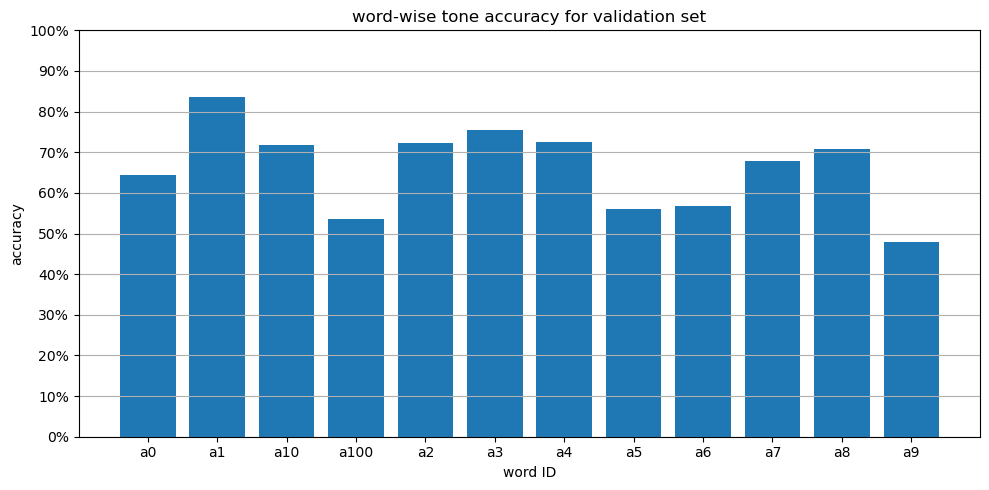

In [44]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
plt.grid(axis='y')
keys = [word_id_to_word[k+1] for k in list(error_rate.keys())]
# sort error_rate based on the keys
error_rate = dict(sorted(error_rate.items(), key=lambda item: word_id_to_word[item[0]+1]))
keys = [word_id_to_word[k+1] for k in list(error_rate.keys())]

plt.bar(keys, [v["correct"] / v["total"] for v in error_rate.values()])
plt.xlabel('word ID')
plt.ylabel('accuracy')
plt.title('word-wise tone accuracy for validation set')
# increase y-ticks
plt.yticks([i/10 for i in range(11)], [f"{i*10}%" for i in range(11)])

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIRECTORY, "word_wise_tone_accuracy.png"))
plt.show()

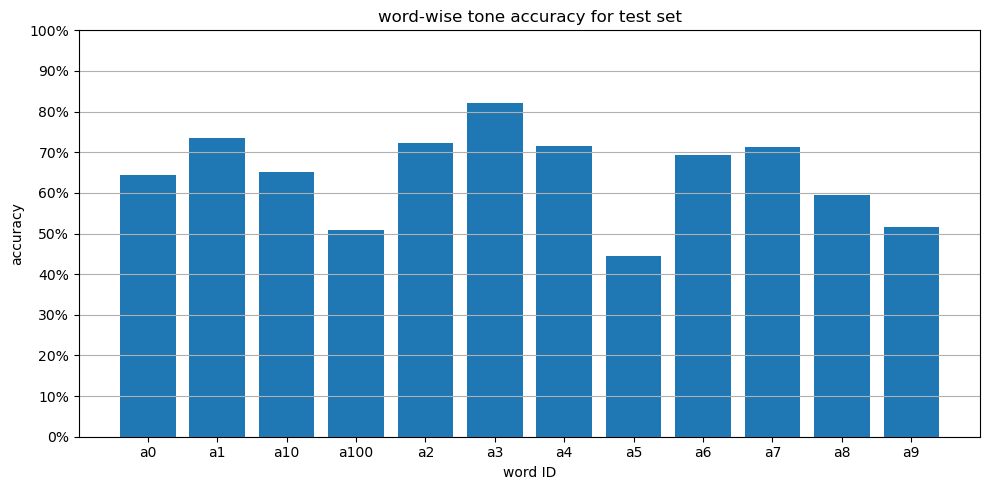

In [45]:
plt.figure(figsize=(10, 5))
plt.grid(axis='y')
error_rate_test = dict(sorted(error_rate_test.items(), key=lambda item: word_id_to_word[item[0]+1]))
tkeys = [word_id_to_word[k+1] for k in list(error_rate_test.keys())]
plt.bar(tkeys, [v["correct"] / v["total"] for v in error_rate_test.values()])
plt.xlabel('word ID')
plt.ylabel('accuracy')
plt.yticks([i/10 for i in range(11)], [f"{i*10}%" for i in range(11)])
plt.title('word-wise tone accuracy for test set')
plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIRECTORY, "word_wise_tone_accuracy_test.png"))
plt.show()

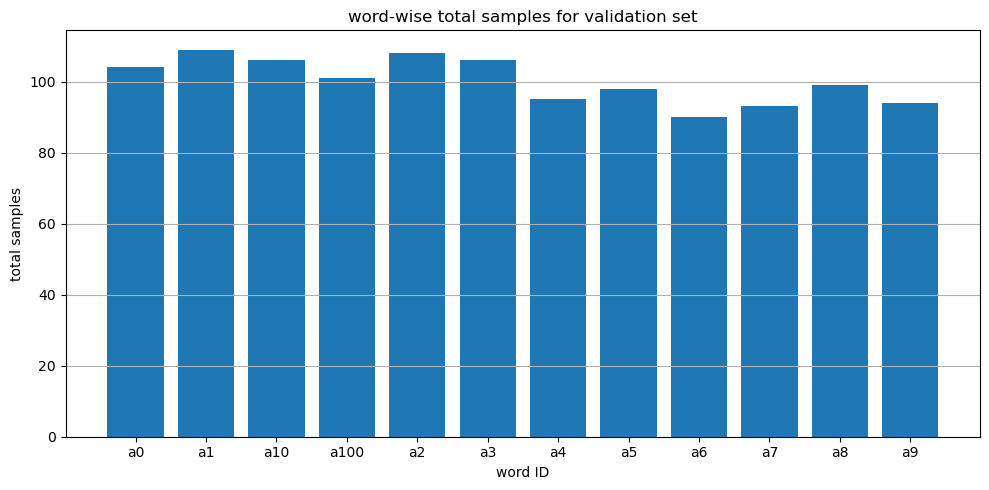

In [36]:
# plots for error_rate total
plt.figure(figsize=(10, 5))
plt.grid(axis='y')
plt.bar(keys, [v["total"] for v in error_rate.values()])
plt.xlabel('word ID')
plt.ylabel('total samples')
plt.title('word-wise total samples for validation set')
plt.tight_layout()
plt.show()

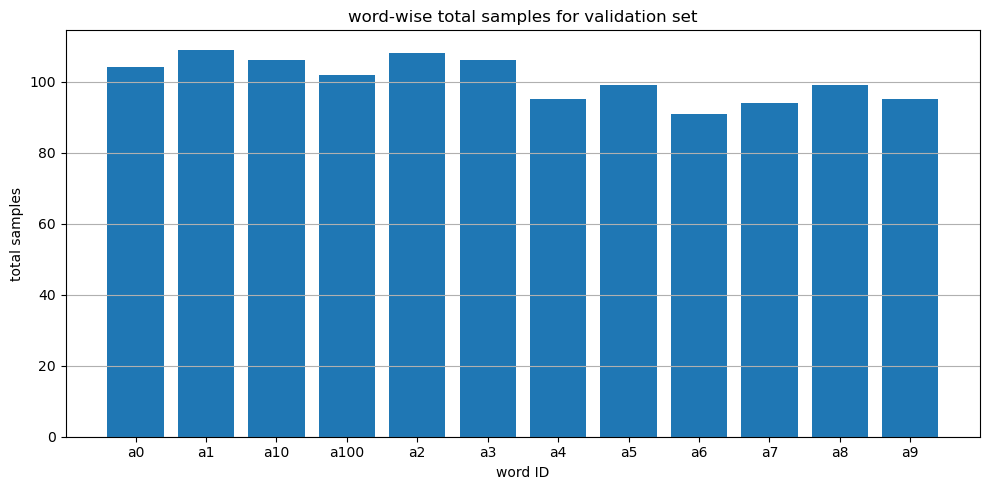

In [37]:
# plots for error_rate total
plt.figure(figsize=(10, 5))
plt.grid(axis='y')
plt.bar(tkeys, [v["total"] for v in error_rate_test.values()])
plt.xlabel('word ID')
plt.ylabel('total samples')
plt.title('word-wise total samples for validation set')
plt.tight_layout()
plt.show()